In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
import matplotlib as mpl

# Add function path
original_path = os.getcwd()
os.chdir(original_path)
function_path = './functions/'
sys.path.append(function_path)

# Import custom functions
from analysis_function import *
from kcc_constrain_function import *
from Plot_function import *
from f1_0_H_sum_multi_region_constrain import *
from f_IMP import *
from f_schemes import *

In [3]:
path = './saved_data/'
file_name = '2.0.real_obs_constrain_prior_post_warming_2016-2025_ref.1850-1900.nc'
prior_post_warm = xr.open_dataarray(path + file_name) 

file_name = '2.1.real_obs_constrain_prior_post_smoothed_series_1850-2025_ref.1850-1900.nc'
prior_post_smooth = xr.open_dataarray(path + file_name) 


### Calculating on large ensemble std(iv)

In [11]:
def load_xr_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


ln_mod_all = load_xr_pickle(path + '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl')

ln_mod_warming = change_ref(ln_mod_all, 1850, 1900).sel(year = slice(2016, 2025)).mean('year')

### the correct way of calculating std(IV)
pseudo_group = list(ln_mod_warming.groupby('model_name'))
pseudo_group_va = [da for name, da in ln_mod_warming.groupby('model_name')]

all_s2 = []

for pseudo_id in range(len(pseudo_group_va)):

    pseudo_ref = pseudo_group_va[pseudo_id].mean(['model_run'])

    bb = ((pseudo_group_va[pseudo_id] - pseudo_ref) ** 2).sum(dim="model_run")

    all_s2.append(bb)

all_s2_xr = xr.concat(all_s2, dim = 'pseudo_id')

counts = ln_mod_warming.groupby('model_name').count(dim='model_run') 
df_total = (counts - 1).sum(dim='model_name')
df_total

pseudo_iv_ln = np.sqrt(all_s2_xr.sum('pseudo_id') / df_total)
pseudo_iv_ln = xr.concat([pseudo_iv_ln.isel(region = slice(0,46)),pseudo_iv_ln.isel(region = 53)], dim = 'region')

In [33]:
post_warming_map

<xarray.DataArray 'prior_warming' (region: 47)> Size: 376B
[47 values with dtype=float64]
Coordinates:
  * region       (region) int64 376B 0 1 2 3 4 5 6 7 ... 39 40 41 42 43 44 45 46
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B 'mean'
    abbrevs      (region) <U4 752B 'GIC' 'NWN' 'NEN' ... 'EAN' 'WAN' 'LSAT'
    names        (region) <U22 4kB ...
    realization  int64 8B ...
    scheme       <U5 20B 'post'

### Plot bar chart of abs magnitude

In [19]:
labels = prior_post_warm.coords['abbrevs'].values

groups = {
    'North and Central America': ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR'],
    'South America': ['NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA'],
    'Europe': ['NEU', 'WCE', 'EEU', 'MED'],
    'Africa': ['SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG'],
    'Asia': ['RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS'],
    'Australasia': ['SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ'],
    'Antarctica': ['EAN', 'WAN'],
    'Global land': ['LSAT']
}

# Create a mapping from abbrev to index
abbrev_to_index = {abbr: i for i, abbr in enumerate(labels)}
continent_indices = {k: [abbrev_to_index[abbr] for abbr in v] for k, v in groups.items()}


colors = {
    'North and Central America': '#c45a5c',  # soft green
    'South America': '#a9b5da',               # lavender blue
    'Europe': '#f5a966',                      # warm yellow-orange
    'Africa': '#bab1a0',                      # muted red
    'Asia': '#b47955',                        # light blue
    'Australasia': '#6e9c6d',                 # forest green
    'Antarctica': '#5590B4',                   # brick red
    'Global land': '#dda15e'
}

uncertainty_ref_period=(1850, 2025)
ref_period=(1850, 1900)
obs_adjust_ref_period=(1961, 2023)
warming_target_period=(2016, 2025)

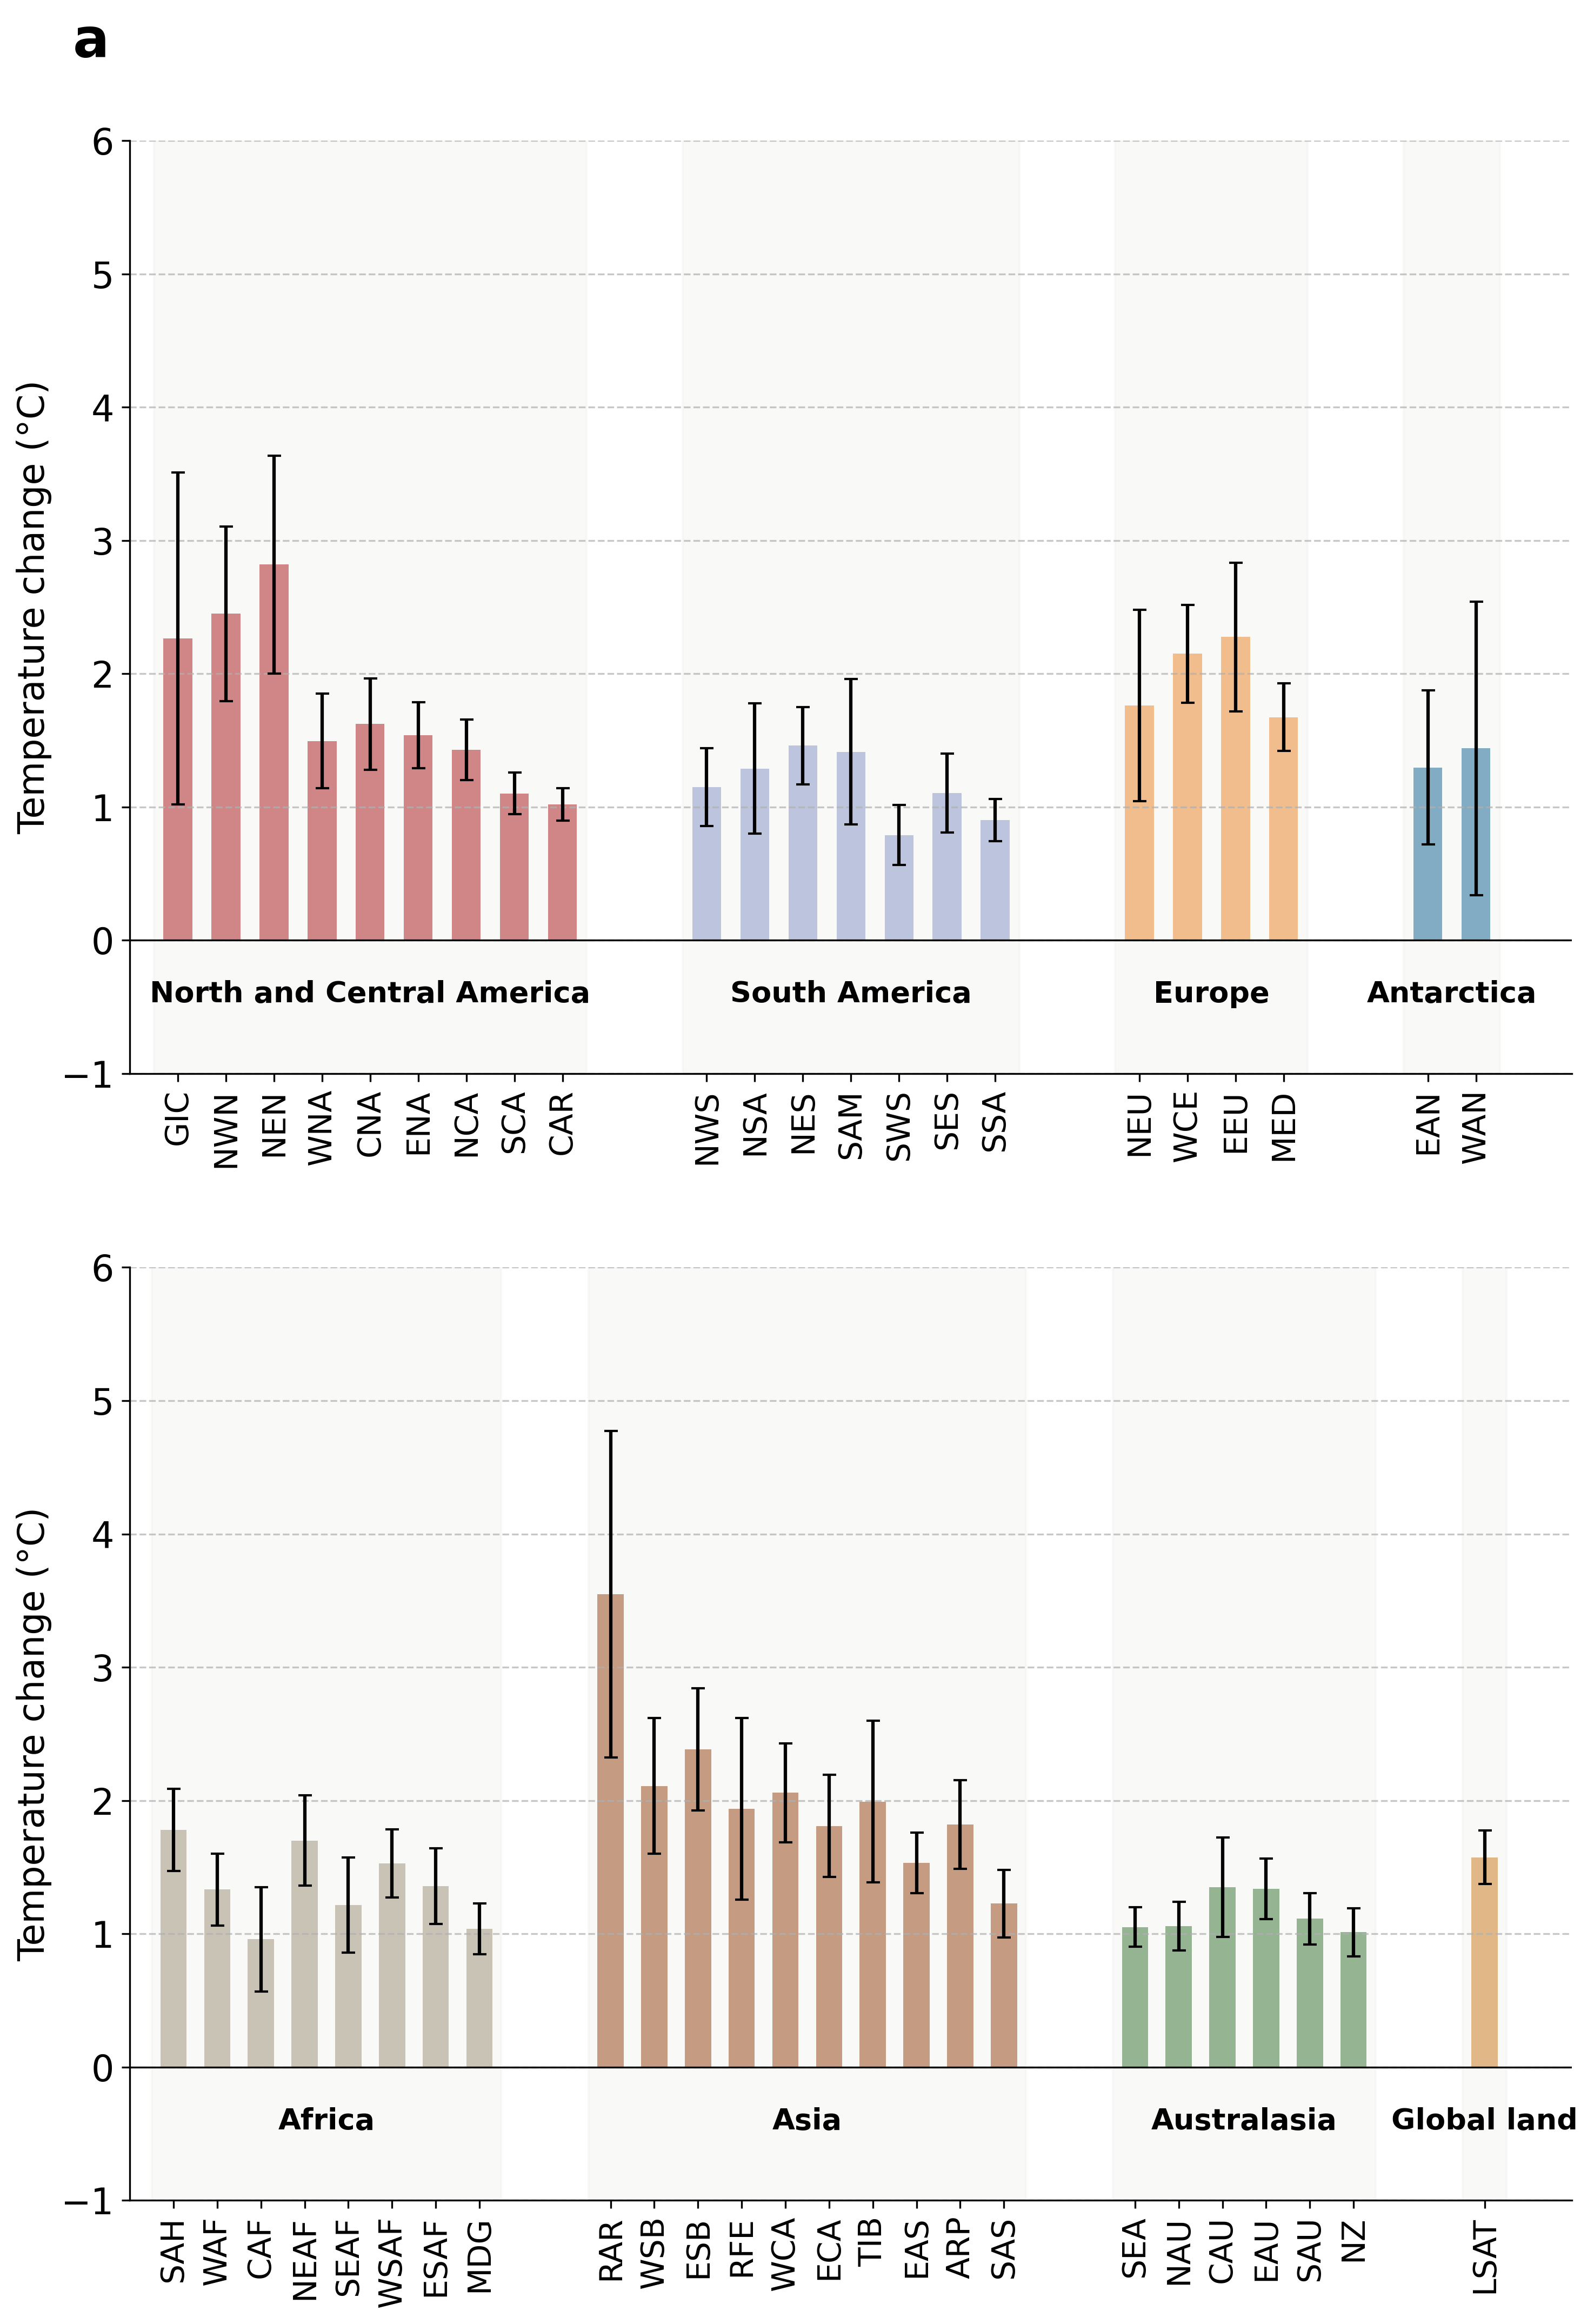

In [46]:

def plot_panel(ax, data, title, colors, continent_indices, labels, y_label, continent_height_value = -0.5, ylim_low = -1, ylim_high = 6, continent_label = 'True'):
    mean = data.sel(quantile='mean')
    err_lower = mean - data.sel(quantile='5th')
    err_upper = data.sel(quantile='95th') - mean

    bar_width = 0.6
    gap = 2

    x_ticks = []
    x_labels = []
    current_x = 0

    for continent, indices in continent_indices.items():
        for idx in indices:
            ax.bar(current_x, mean[idx], 
                   yerr=[[err_lower[idx]], [err_upper[idx]]],
                   color=colors[continent], capsize=3, alpha=1, width = bar_width)
            x_ticks.append(current_x)
            x_labels.append(labels[idx])
            current_x += 1
        current_x += gap

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=90, fontsize=14)
    ax.set_ylabel(y_label, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(title, loc='left', fontsize=24, fontweight='bold')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)


    # Background and continent labels
    current_x = 0
    for continent, indices in continent_indices.items():
        group_width = len(indices)
        ax.axvspan(current_x - 0.5, current_x + group_width - 0.5, color='#edede9', alpha=0.3)
        group_center = current_x + group_width / 2 - 0.5

        if continent_label == 'True':
            ax.text(group_center, continent_height_value,
                    continent, ha='center', va='top', fontsize=13, fontweight='bold')
        current_x += group_width + gap

    ax.set_ylim(ylim_low, ylim_high)
    ax.set_xlim(-1, current_x - gap + 1)  # enforce same scaling

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
post_warming = prior_post_warm.sel(scheme = 'post', forcing = 'ALL')


continent_indices_top = {
    "North and Central America": continent_indices["North and Central America"],
    "South America": continent_indices["South America"],
    "Europe": continent_indices["Europe"],
    "Antarctica": continent_indices["Antarctica"],   # 👈 move Antarctica up
}

continent_indices_bottom = {
    "Africa": continent_indices["Africa"],
    "Asia": continent_indices["Asia"],
    "Australasia": continent_indices["Australasia"],
    "Global land": continent_indices["Global land"],
}

import matplotlib.pyplot as plt
from matplotlib import gridspec

# Count how many x positions in each panel
n_top = sum(len(v) for v in continent_indices_top.values())
n_bottom = sum(len(v) for v in continent_indices_bottom.values())

gap = 2  # same as in your plot_panel
span_top = n_top + (len(continent_indices_top)-1) * gap
span_bottom = n_bottom + (len(continent_indices_bottom)-1) * gap
# Create the figure with two rows instead of one
fig, axs = plt.subplots(2, 1, figsize=(10, 14), dpi=300, sharey=True)

# Top panel
plot_panel(
    axs[0],
    post_warming,
    ' ',
    colors,
    continent_indices_top,
    labels,
    'Temperature change (°C)',
    continent_height_value=-0.3,  # lift up labels for tighter spacing
    ylim_low=-1,
    ylim_high=6
)

# Bottom panel
plot_panel(
    axs[1],
    post_warming,
    ' ',
    colors,
    continent_indices_bottom,
    labels,
    'Temperature change (°C)',
    continent_height_value=-0.3,
    ylim_low=-1,
    ylim_high=6
)

plt.tight_layout(h_pad=2.0)  # reduce vertical spacing between subplots
main_title = f"a"
fig.suptitle(main_title, fontsize=24, fontweight='bold', x = 0.05, y=1.02, ha = 'left')

plt.show()

/var/folders/jt/kr53pz_j4x3d_32xbfb7pkd87_b0mf/T/ipykernel_56912/3487945480.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(name)


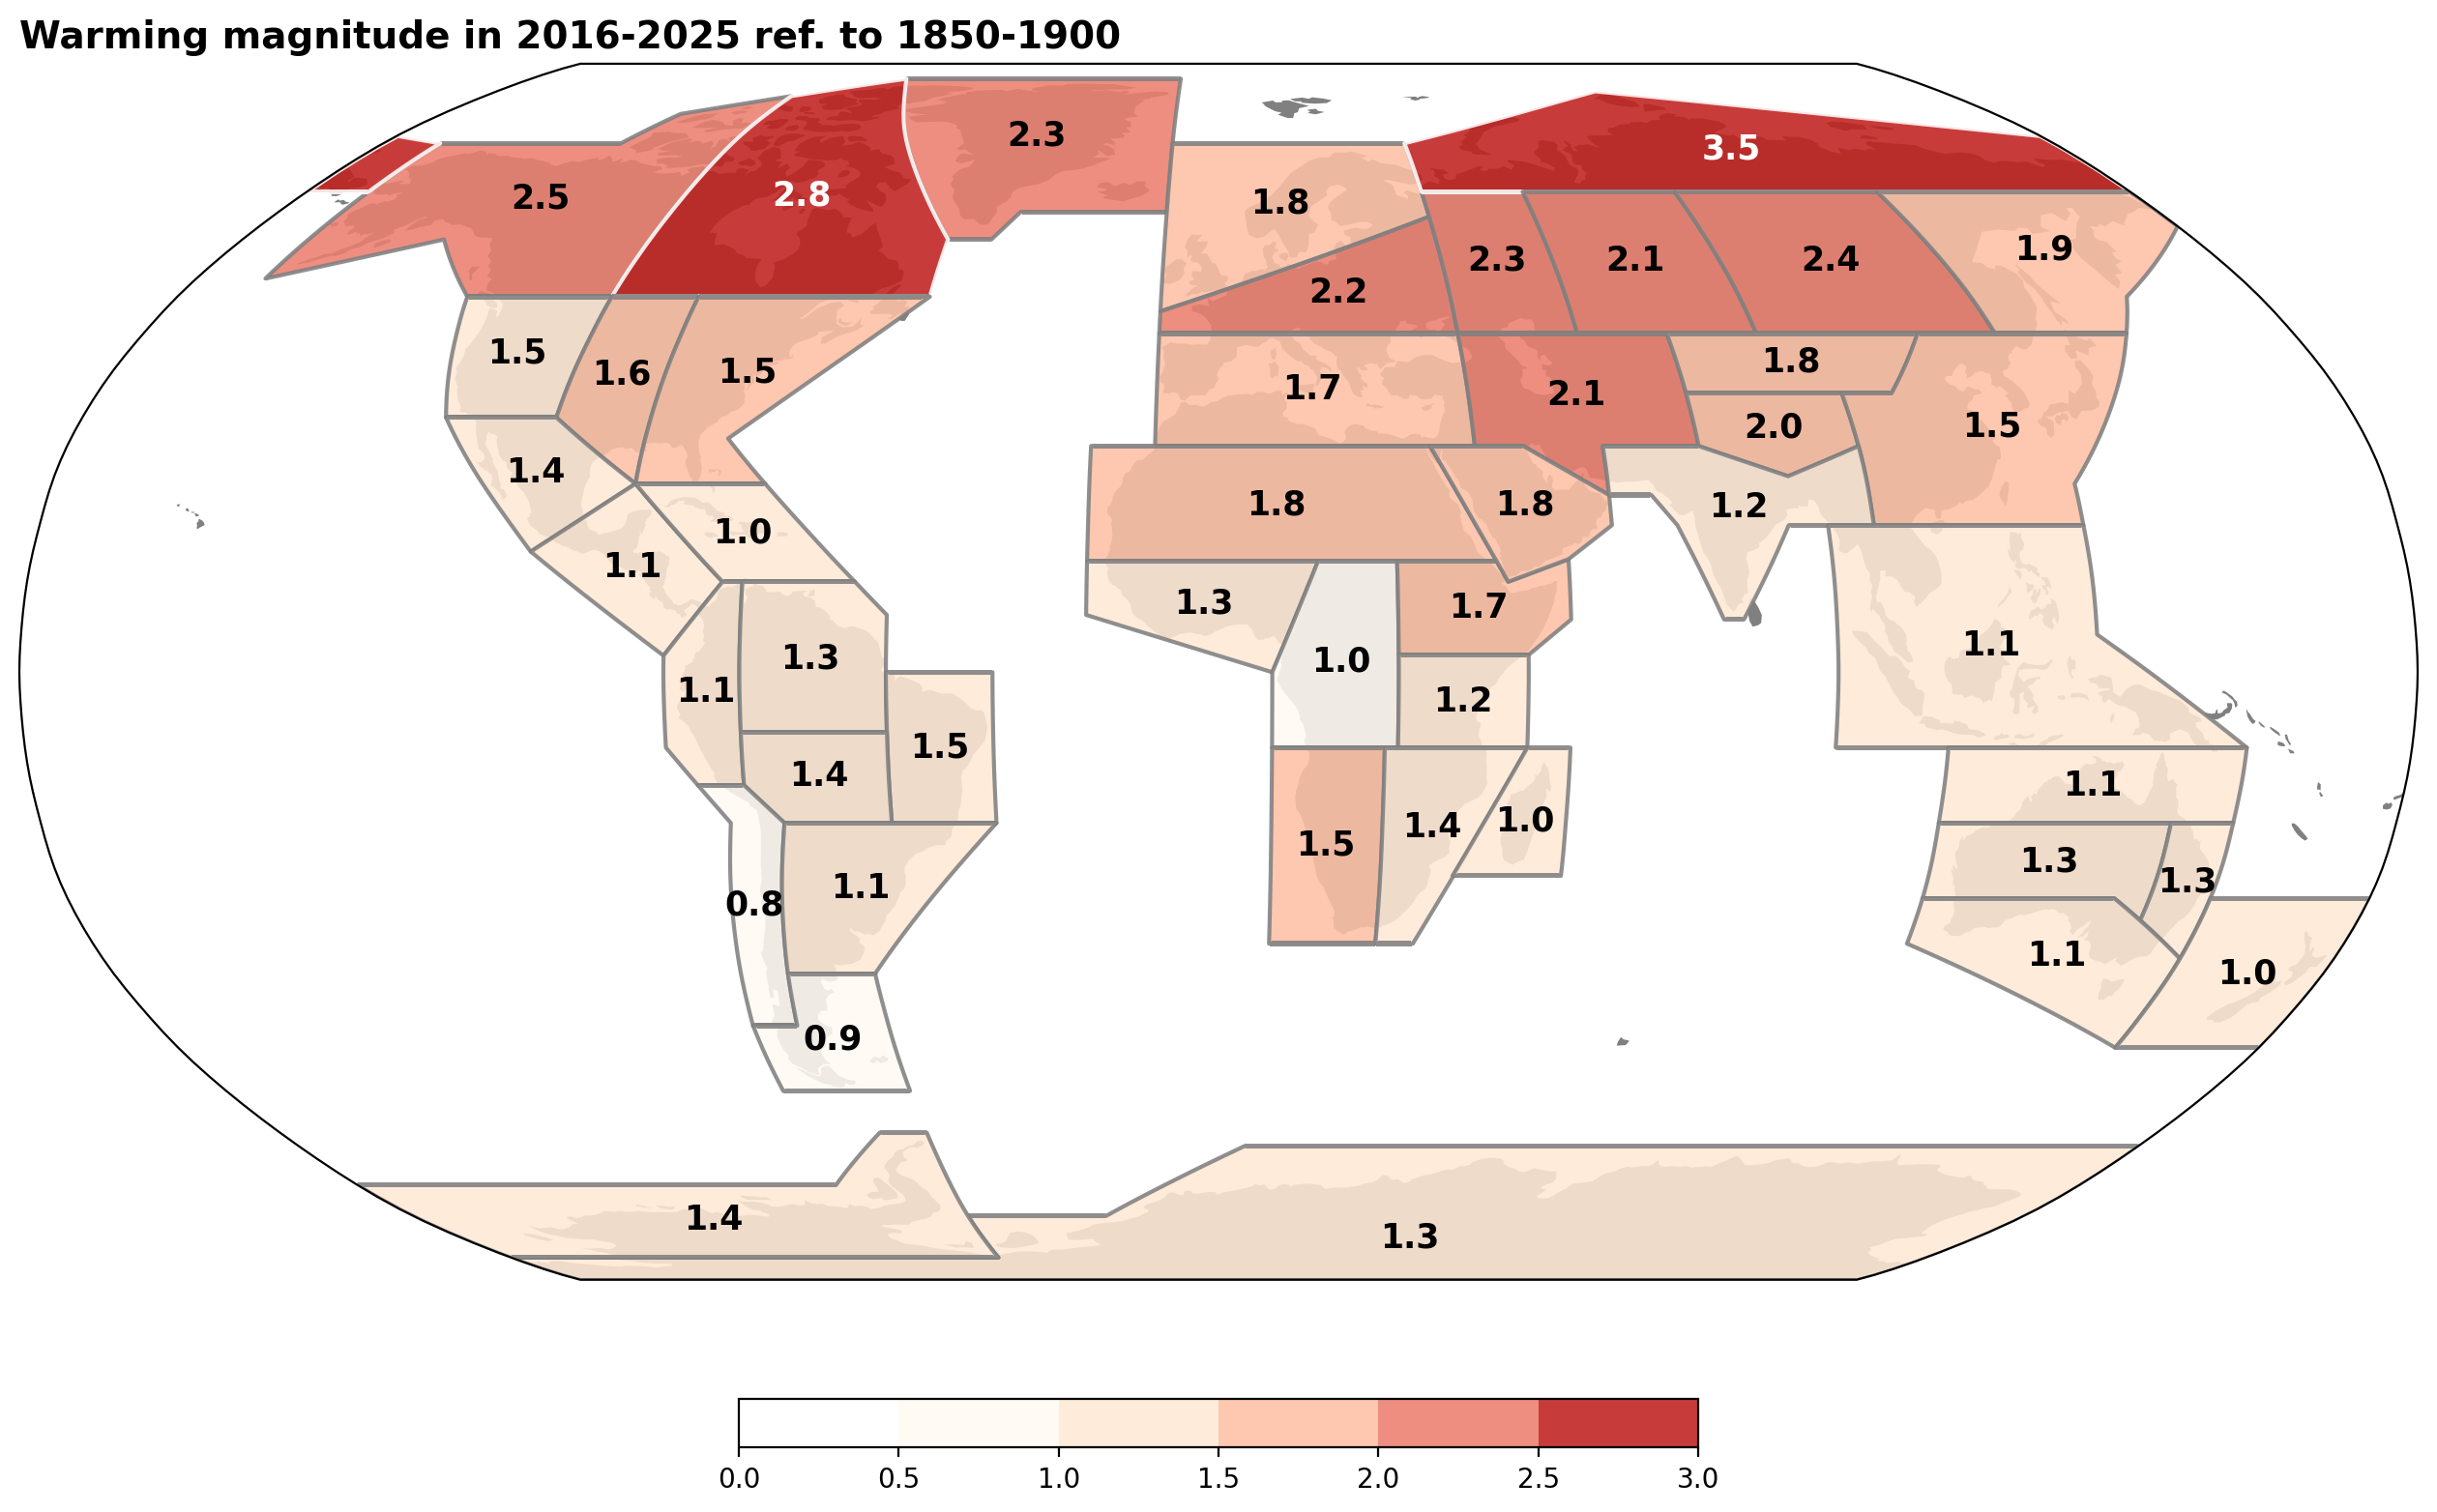

In [59]:
post_warming_map = prior_post_warm.sel(scheme = 'post', forcing = 'ALL', quantile = 'mean').isel(region = slice(0, 46))
post_warming_map


from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def modify_cmap(name='YlGn', start=0.1, end=0.9, gamma=0.8, white_strength=0.3):
    """
    white_strength = 0 → no whitening
    white_strength = 1 → pure white at start
    """
    base = cm.get_cmap(name)
    colors = base(np.linspace(start, end, 256))[:, :3] ** gamma
    
    # Blend first colors toward white
    white = np.array([1, 1, 1])
    for i in range(len(colors)):
        blend_factor = (1 - i / (len(colors)-1)) * white_strength
        colors[i] = (1-blend_factor)*colors[i] + blend_factor*white
    
    return ListedColormap(colors)


cmap = modify_cmap('OrRd', start=0.0, end=0.95, gamma=1.0, white_strength=1.0)

colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[0:230]
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)


# --- Plot panels ---
fig, axes = plt.subplots(1,1, figsize=(16, 16), subplot_kw={'projection': ccrs.Robinson()}, dpi=200)

axes.set_global()

bounds = np.arange(0.0, 3.5, 0.5)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax_new(axes, post_warming_map, cmap=truncated_cmap, norm=norm, decimals=1)
axes.set_title("Warming magnitude in 2016-2025 ref. to 1850-1900", fontsize=14, fontweight='bold', loc='left')
# axes.set_title("a", fontsize=14, fontweight='bold', loc='left')

# --- Shared colorbar ---
def set_cmap_alpha(cmap, alpha=1.0):
    """Return a copy of cmap with uniform alpha applied."""
    colors = cmap(np.arange(cmap.N))       # RGBA array
    colors[:, -1] = alpha                  # set alpha channel
    return mpl.colors.ListedColormap(colors)

# Example usage
cmap_with_alpha = set_cmap_alpha(truncated_cmap, alpha=0.88)

sm = mpl.cm.ScalarMappable(cmap=cmap_with_alpha, norm=norm0)
sm.set_array([])

cb = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.05, shrink=0.4)



plt.show()

In [64]:
(prior_post_warm.sel(scheme = 'post', forcing = 'ALL', quantile = '5th').isel(region = slice(0, 46))>0.5)

<xarray.DataArray 'prior_warming' (region: 46)> Size: 46B
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])
Coordinates:
  * region       (region) int64 368B 0 1 2 3 4 5 6 7 ... 38 39 40 41 42 43 44 45
    forcing      <U3 12B 'ALL'
    quantile     <U4 16B '5th'
    abbrevs      (region) <U4 736B 'GIC' 'NWN' 'NEN' 'WNA' ... 'NZ' 'EAN' 'WAN'
    names        (region) <U22 4kB ...
    realization  int64 8B ...
    scheme       <U5 20B 'post'

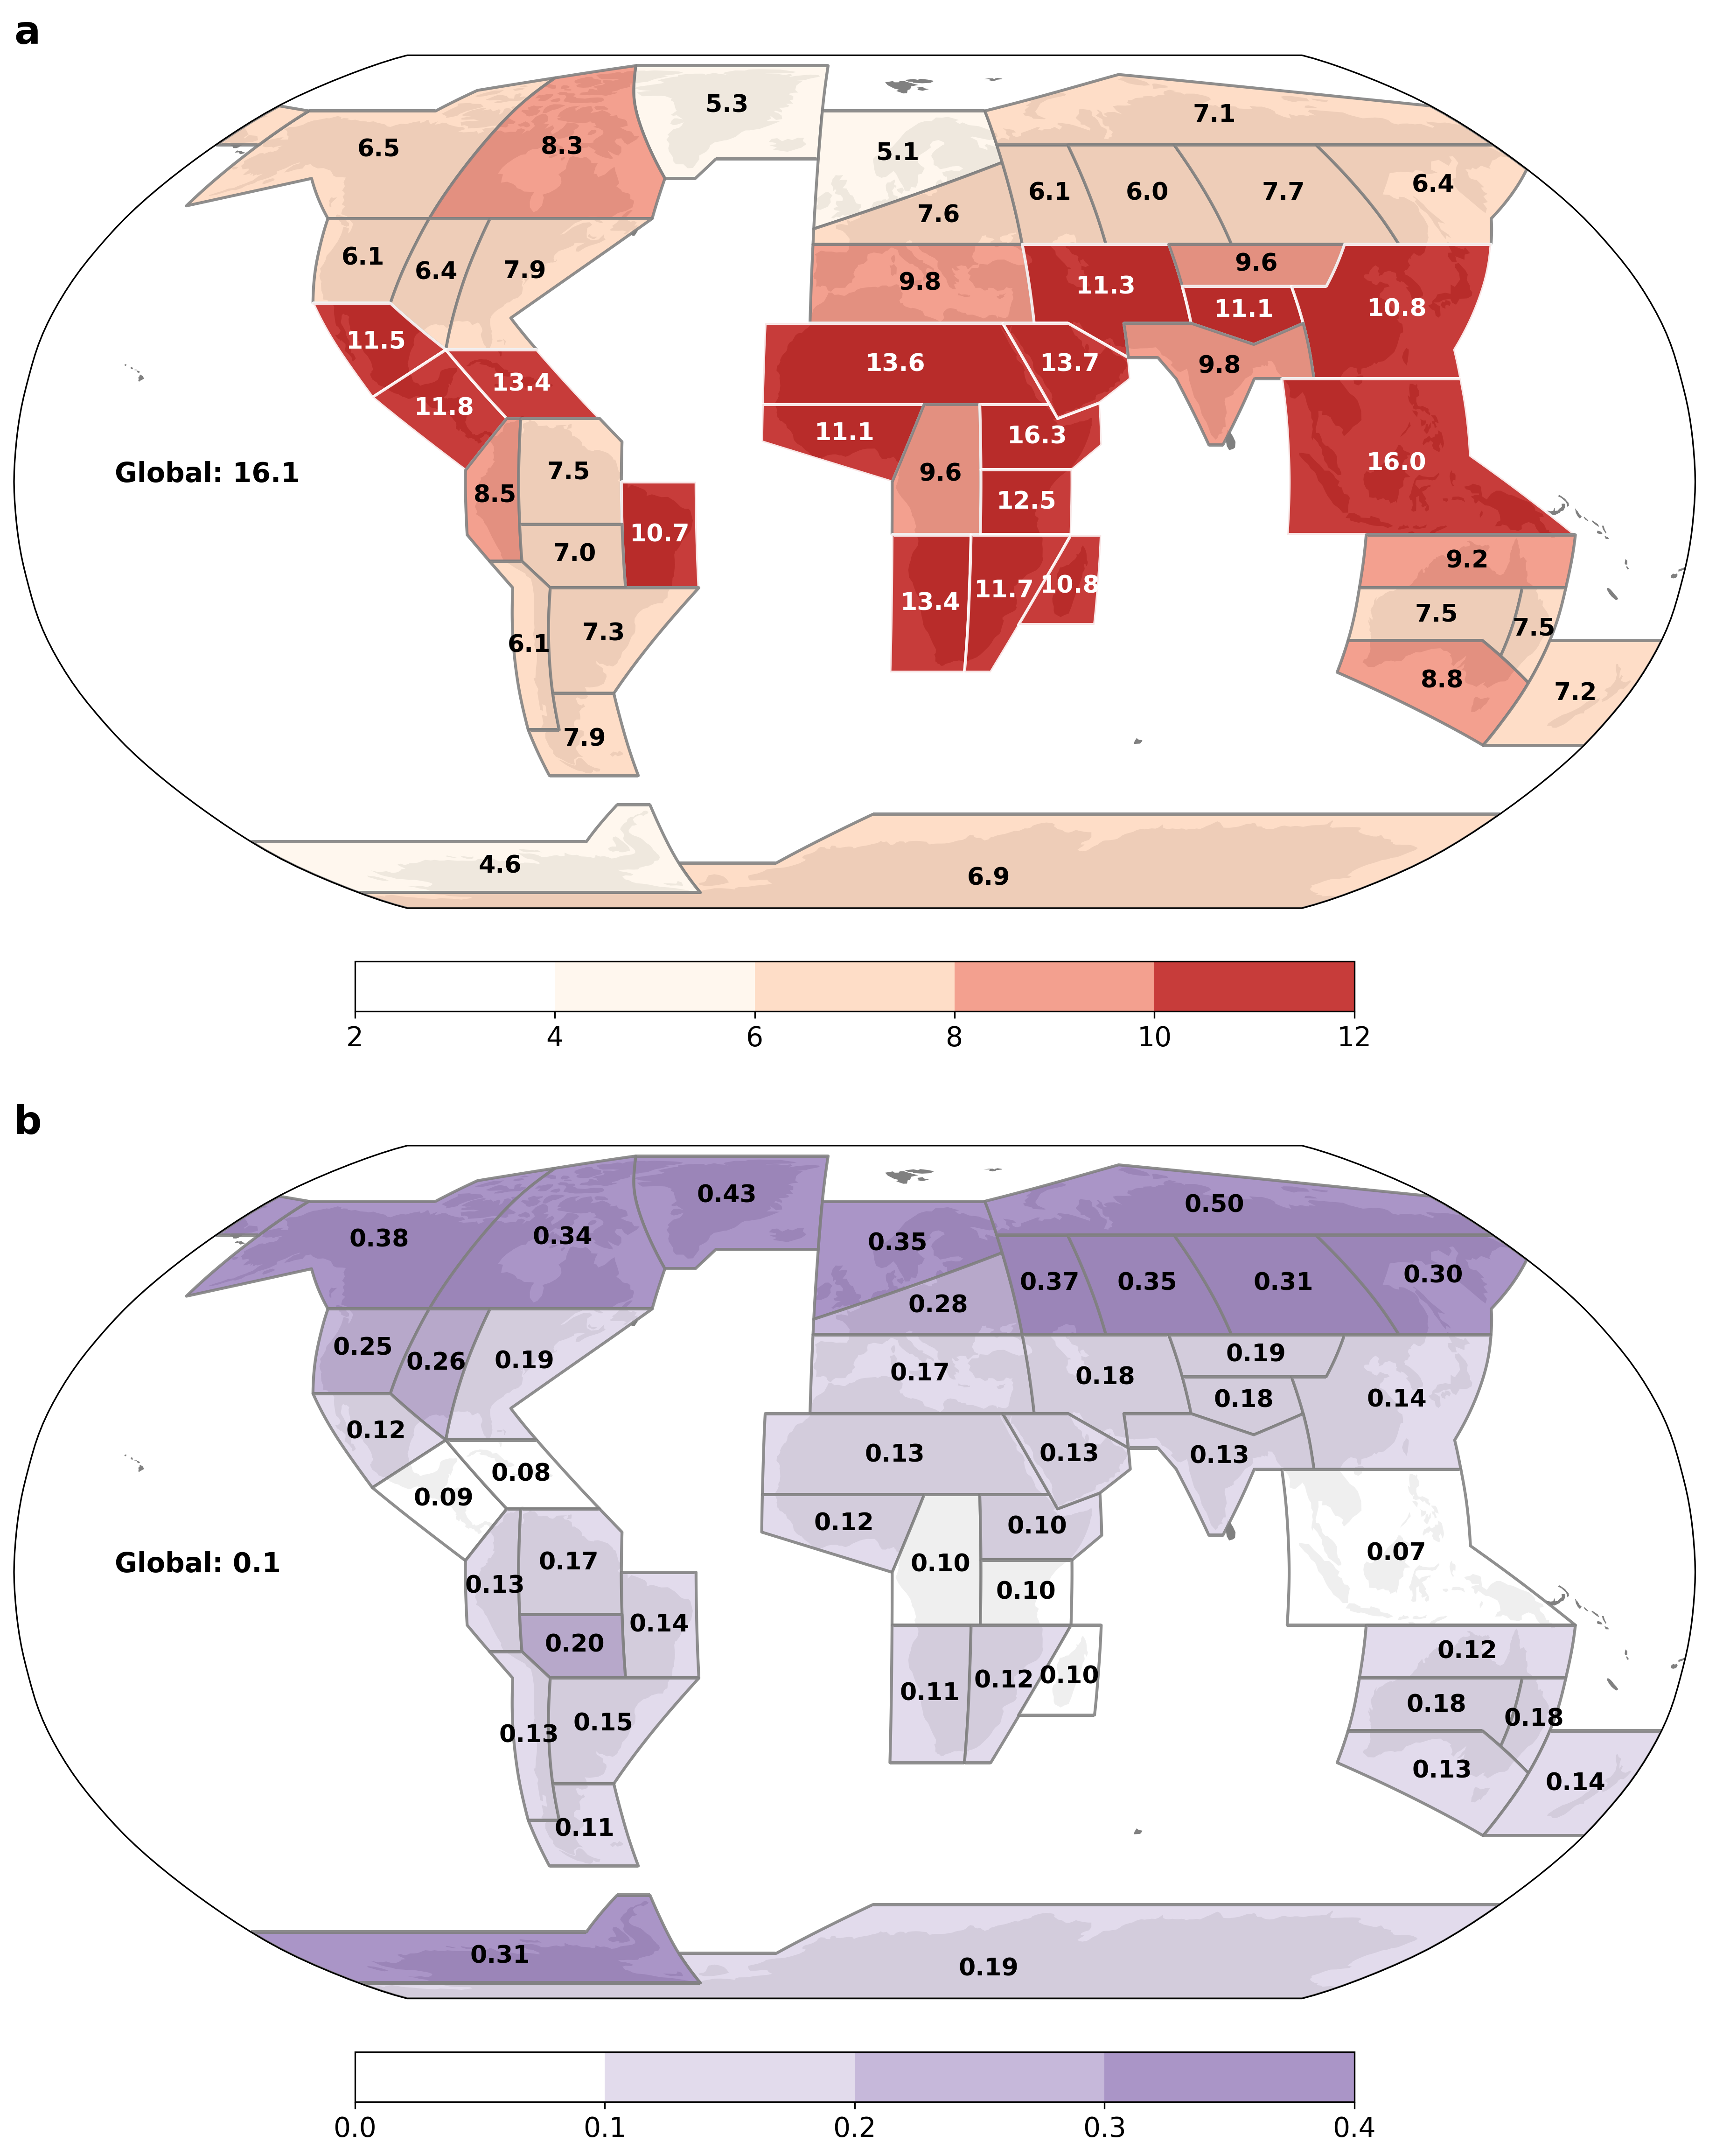

In [40]:
### Data preparation
post_warming_map = prior_post_warm.sel(scheme = 'post', forcing = 'ALL', quantile = 'mean')

warming_iv_std = post_warming_map / pseudo_iv_ln.assign_coords(region=post_warming_map['region'])

warming_iv_ratio_region = warming_iv_std.isel(region = slice(0,46))

std_iv_region = pseudo_iv_ln.assign_coords(region=post_warming_map['region']).isel(region = slice(0,46))

warming_iv_ratio_glob = warming_iv_std.isel(region = 46)

std_iv_glob = pseudo_iv_ln.assign_coords(glob=post_warming_map['region']).isel(region = 46)
unit = ' '

#### plot
cmap = modify_cmap('OrRd', start=0.0, end=0.95, gamma=1.0, white_strength=1.0)

colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[0:230]
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)

# --- Plot panels ---
fig, axes = plt.subplots(2,1, figsize=(36, 16), subplot_kw={'projection': ccrs.Robinson()}, dpi=300)

ax = axes[0]

ax.set_global()

bounds = np.arange(2, 14, 2)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax_new(ax, warming_iv_ratio_region, cmap=truncated_cmap, norm=norm, decimals=1)
ax.set_title("Warming magnitude / std (IV) (Fig. S2a)", fontsize=14, fontweight='bold', loc='left')
ax.set_title("a", fontsize=20, fontweight='bold', loc='left')


ax.text(
            0.06, 0.5,
            f"Global: {warming_iv_ratio_glob:.1f}{unit}",   # unit inserted here
            transform=ax.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )

def set_cmap_alpha(cmap, alpha=1.0):
    """Return a copy of cmap with uniform alpha applied."""
    colors = cmap(np.arange(cmap.N))       # RGBA array
    colors[:, -1] = alpha                  # set alpha channel
    return mpl.colors.ListedColormap(colors)

cmap_with_alpha = set_cmap_alpha(truncated_cmap, alpha=0.88)

sm = mpl.cm.ScalarMappable(cmap=cmap_with_alpha, norm=norm0)
sm.set_array([])

cb = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, shrink=0.2)
cb.ax.tick_params(labelsize=14)   # change 14 to any size you want

############# Panel b
ax = axes[1]


from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list("red_white", ["white", "#9f86c0"])

colors_array = cmap(np.linspace(0, 1, 256))
truncated_colors = colors_array[0:256]
truncated_cmap = mcolors.LinearSegmentedColormap.from_list('truncated_YlOrBr', truncated_colors)


ax.set_global()

bounds = np.arange(0, 0.5, 0.1)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='neither')

norm0 = plot_ar6_region_data_on_ax_new(ax, std_iv_region, cmap=truncated_cmap, norm=norm, decimals = 2)
ax.set_title("Standard deviation of IV (Fig. S2b)", fontsize=14, fontweight='bold', loc='left')
ax.set_title("b", fontsize=20, fontweight='bold', loc='left')

ax.text(
            0.06, 0.5,
            f"Global: {std_iv_glob:.1f}{unit}",   # unit inserted here
            transform=ax.transAxes,
            fontsize=14,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=4)
        )

# --- Shared colorbar ---
# Example usage
cmap_with_alpha = set_cmap_alpha(truncated_cmap, alpha=0.88)

sm = mpl.cm.ScalarMappable(cmap=cmap_with_alpha, norm=norm0)
sm.set_array([])

cb = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.05, shrink=0.2)
cb.ax.tick_params(labelsize=14)   # change 14 to any size you want
plt.tight_layout()

plt.show()

In [53]:
# Create the figure with four subplots
fig, axs = plt.subplots(4, 1, figsize=(22, 21), dpi=400, sharey=False)
axs = axs.flatten()
# Plot prior and posterior
plot_panel(axs[0], prior_post_warm.sel(scheme = 'post', forcing = 'ANT'), 'a', colors, continent_indices, labels, 'ANT (°C)', ylim_low = -1, ylim_high = 6, continent_label = 'True')
plot_panel(axs[1], prior_post_warm.sel(scheme = 'post', forcing = 'NAT'), 'b', colors, continent_indices, labels, 'NAT (°C)', ylim_low = -1.0, ylim_high = 1.5, continent_height_value = -1, continent_label = 'False')
plot_panel(axs[2], prior_post_warm.sel(scheme = 'post', forcing = 'GHG'), 'c', colors, continent_indices, labels, 'GHG (°C)', ylim_low = -1, ylim_high = 6, continent_label = 'False')
plot_panel(axs[3], prior_post_warm.sel(scheme = 'post', forcing = 'OA'), 'd', colors, continent_indices, labels, 'OANT (°C)', ylim_low = -4.2, ylim_high = 2, continent_height_value = 1.6, continent_label = 'False')


plt.tight_layout(h_pad = 3)
# main_title = f"Attributable warming in {warming_target_period[0]}-{warming_target_period[1]} rel. to {ref_period[0]}-{ref_period[1]}"
# fig.suptitle(main_title, fontsize=20, fontweight='bold', y=1.02)

plt.show()

In [71]:
ratio_ghg_all = ((prior_post_warm.sel(scheme = 'post', forcing = 'GHG') - prior_post_warm.sel(scheme = 'post', forcing = 'ALL'))/ prior_post_warm.sel(scheme = 'post', forcing = 'ALL')).sel(quantile = 'mean')

ratio_ghg_all.quantile([0.25, 0.75])

<xarray.DataArray 'prior_warming' (quantile: 2)> Size: 16B
array([0.04050894, 0.24127722])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75

In [74]:
prior_post_warm.sel(scheme = 'post', forcing = 'OA').median()

<xarray.DataArray 'prior_warming' ()> Size: 8B
array(-0.30458514)
Coordinates:
    forcing      <U3 12B 'OA'
    realization  int64 8B ...
    scheme       <U5 20B 'post'

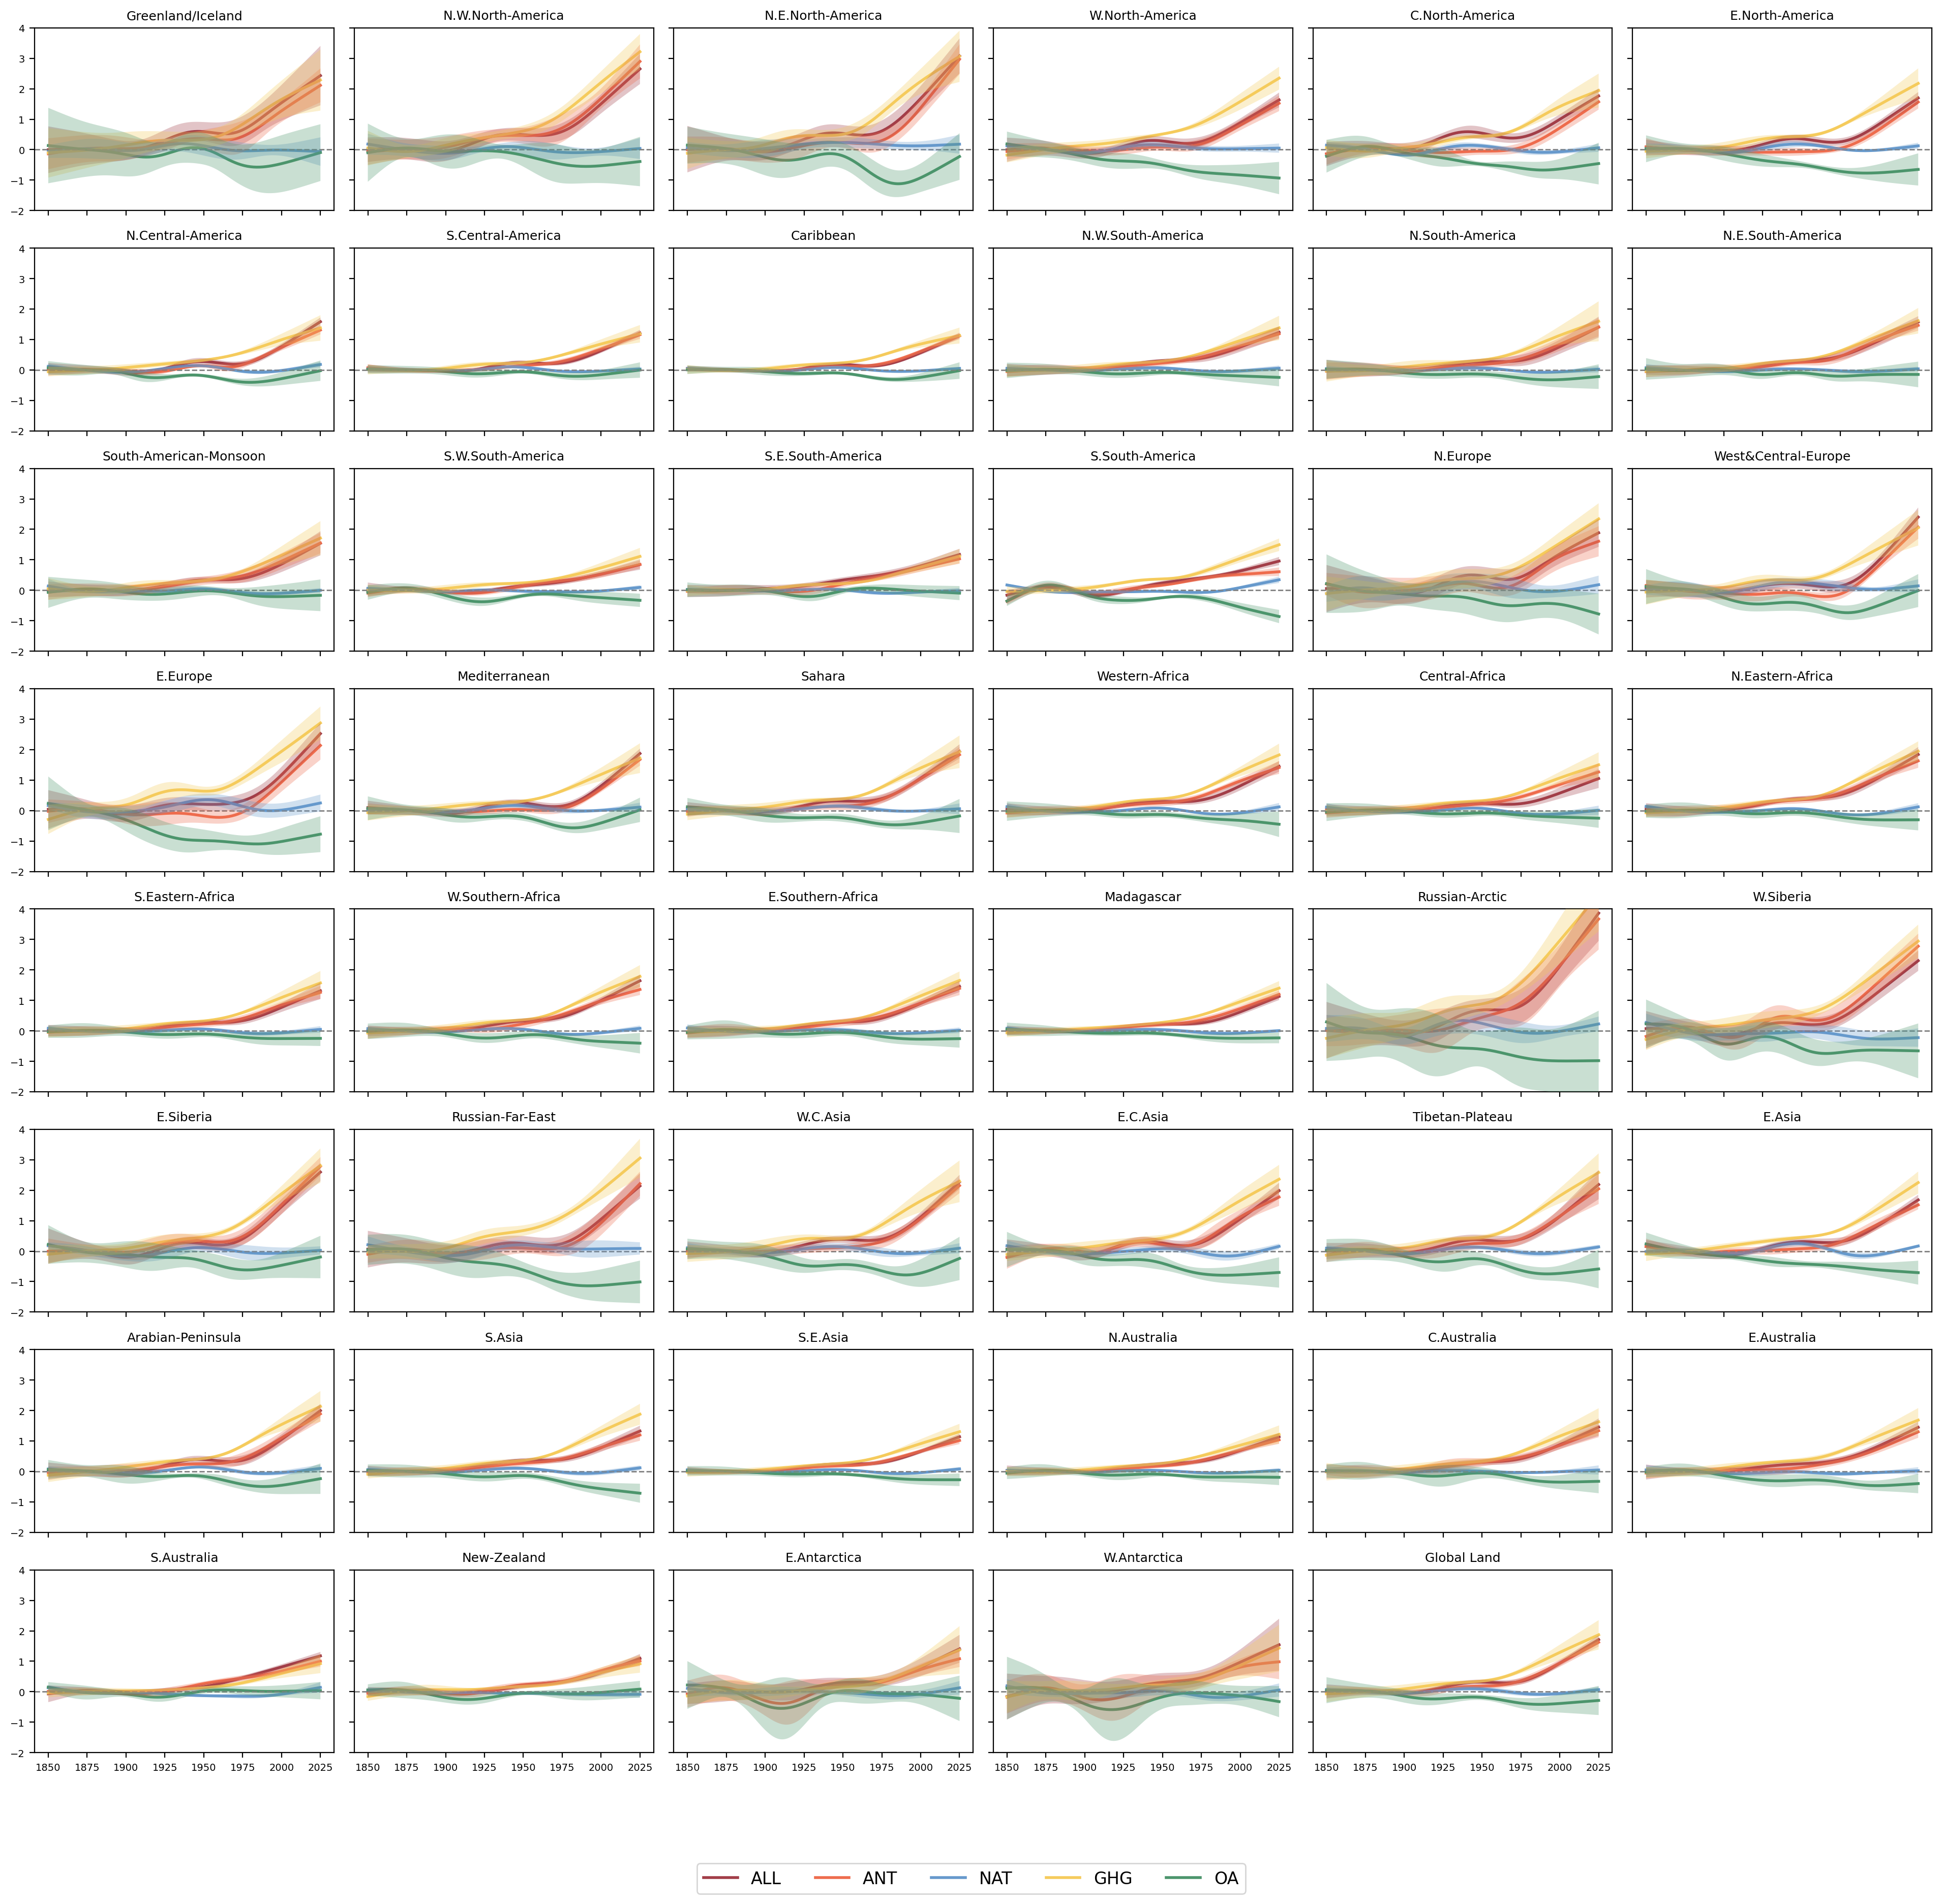

In [57]:
# Parameters
region_names = list(prior_post_smooth.names.values)

colors_forcings = ['#a23e48', '#ee6c4d', '#6699CC', '#F5CB5C', '#4C956C']  # 'ALL' 'ANT' 'NAT' 'GHG' 'OA'


nrows, ncols = 8, 6
fig, axes = plt.subplots(nrows, ncols, figsize=(3.2 * ncols, 2.3 * nrows), dpi=200, sharex=True, sharey=True)
axes = axes.flatten()

# For collecting legend handles (only from first region)
legend_lines = []
legend_labels = []

for r_id, ax in enumerate(axes):
    if r_id >= len(region_names):
        ax.axis('off')
        continue

    data1 = prior_post_smooth.sel(scheme = 'prior')[r_id]
    data2 = prior_post_smooth.sel(scheme = 'post')[r_id]
    forcings1 = data1.forcing.values

    for i, forcing in enumerate(forcings1):
        # Individual
        # line1, = ax.plot(data1['year'], data1.sel(quantile='mean')[i, :], linestyle='--', color=colors1[i])
        # Sum
        line2, = ax.plot(data2['year'], data2.sel(quantile='mean')[i, :], linestyle='-', color=colors_forcings[i], lw = 2)
        
        # Shading
        # plot_shading(ax, data1['year'], data1.sel(quantile='5th')[i, :], data1.sel(quantile='95th')[i, :], color='gray', alpha=0.2)
        plot_shading(ax, data2['year'], data2.sel(quantile='5th')[i, :], data2.sel(quantile='95th')[i, :], color=colors_forcings[i], alpha=0.3)

        if r_id == 0:
            legend_lines.extend([line2])
            legend_labels.extend([f'{forcing}'])

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_ylim(-2, 4)
    ax.set_title(region_names[r_id], fontsize=9)
    ax.tick_params(labelsize=7)

# Add global legend below the plots
fig.legend(
    handles=legend_lines,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=5,
    fontsize=12
)

plt.tight_layout()  # Leave space at bottom for legend
plt.subplots_adjust(bottom=0.06)  # Fine-tune the bottom space

plt.show() 